Introducir archivos PDF de CILAS para usar:

In [ ]:
input_a = 'file_input_uploads/GeoB22729.pdf'

In [ ]:
!pip install PyPDF2


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
import os
import csv
from PyPDF2 import PdfReader
import pandas as pd
import numpy as np
from IPython.display import display, HTML

def process_data(df):
    matrices = []
    for i in range(len(df) - 32):  # Iterar hasta la fila 30 antes del final del DataFrame
        if df.iloc[i, 0] == 'x' and df.iloc[i + 1, 0] == 'Q3' and df.iloc[i + 2, 0] == 'q3':
            values = df.iloc[i + 3:i + 33, 0].values  # Tomar las siguientes 30 filas
            matrix = [values[j::3] for j in range(3)]  # Crear la matriz 3x10 con los elementos organizados según lo especificado
            matrices.append(matrix)

    groups_of_10 = [matrices[x:x + 10] for x in range(0, len(matrices), 10)]

    concatenated_matrices = []
    for group in groups_of_10:
        concatenated_group = [np.hstack(subgroup) for subgroup in zip(*group)]
        concatenated_matrices.extend(concatenated_group)

    return pd.DataFrame(concatenated_matrices)

def pdf_to_csv(input_pdf, output_csv):
    with open(input_pdf, 'rb') as pdf_file:
        pdf_reader = PdfReader(pdf_file)

        with open(output_csv, 'w', newline='', encoding='utf-8') as csv_file:
            csv_writer = csv.writer(csv_file)

            for page in pdf_reader.pages:
                lines = page.extract_text().split('\n')

                for line in lines:
                    words = line.split()
                    for word in words:
                        csv_writer.writerow([word])

    # Leer el archivo CSV original
    df = pd.read_csv(output_csv, header=None)
    df_processed = process_data(df)

    nombre = []
    for i in range(len(df)):
        if (df.iloc[i, 0] == 'Sample' and df.iloc[i + 1, 0] == 'ref.' and df.iloc[i + 2, 0] == ':'):
            value = df.iloc[i + 3, 0] + '_' + df.iloc[i + 4, 0] + df.iloc[i + 5, 0]
            nombre.append(value)

    muestra = [palabra.replace('Sample', '') if 'Sample' in palabra else palabra for palabra in nombre]
    muestra = [item for sublist in [(val, '*', '*') for val in muestra] for item in sublist]
    muestra = pd.DataFrame(muestra)

    nueva_columna = np.array(["x", "Q3", "q3"] * (len(df_processed) // 3)).reshape(-1, 1)
    nueva_columna = pd.DataFrame(nueva_columna)

    matrices = []
    with open(output_csv, newline='') as file:
        reader = csv.reader(file)
        for row in reader:
            matrices.append(row)

    matrices_con_columna = pd.concat([muestra, nueva_columna, pd.DataFrame(df_processed)], axis=1)
    salida_modificada = input_pdf.split('.')[0] + ".csv"
    matrices_con_columna.to_csv(salida_modificada, index=False, header=False)

def process_all_pdfs(directory):
    # Listar todos los archivos PDF en el directorio especificado
    pdf_files = [f for f in os.listdir(directory) if f.endswith('.pdf')]
    
    if not pdf_files:
        display(HTML("<h3>No se encontraron archivos PDF en el directorio.</h3>"))
        return
    
    for pdf_file in pdf_files:
        input_pdf_path = os.path.join(directory, pdf_file)
        output_csv_path = 'auxiliar.csv'
        pdf_to_csv(input_pdf_path, output_csv_path)
        display(HTML(f"<h3>Procesamiento completo para {pdf_file}</h3>"))



def main():
    # Directorio donde están los archivos PDF
    directory = 'file_input_uploads'
    process_all_pdfs(directory)

if __name__ == "__main__":
    main()

Del CSV generado se crean los gráficos necesarios de cada muestra, y el diagrama Ternario de Shepard 1979

In [ ]:
import os

# Ruta a la carpeta que contiene los archivos CSV
ruta_carpeta = '/work/file_input_uploads'  # Reemplaza con la ruta de tu carpeta

# Listar todos los archivos en la carpeta
archivos = os.listdir(ruta_carpeta)

# Filtrar los archivos CSV
csv_archivos = [archivo for archivo in archivos if archivo.endswith('.csv')]

# Mostrar los archivos CSV encontrados
for archivo in csv_archivos:
    print(archivo)

GeoB22729-20240806-004219.csv
GeoB22729.csv
T 30 (1).csv
T 30.csv
T_30.csv


Copiar el nombre del archivo csv con el que se quiere trabajar y pegarlo en el casillero de abajo

In [ ]:
input_csv = 'GeoB22729.csv'

In [ ]:
import pandas as pd

# Ruta del archivo CSV
csv_path = '/work/file_input_uploads/'+input_csv

# Leer el archivo CSV
df = pd.read_csv(csv_path)

# Filtrar las columnas necesarias: Primer columna, x=3, x=56 y x=2500
filtro_aux = df.iloc[:, [0, 24, 55, -1]]
filtro_aux.columns = ['Sample', 'x_3', 'x_56', 'x_2500']


# Crear un DataFrame para los nombres de las columnas como una fila
columnas = pd.DataFrame([list(df.columns[[0, 24, 55, -1]])], columns=['Sample', 'x_3', 'x_56', 'x_2500'])


# Concatenar verticalmente los nombres de las columnas con el DataFrame filtro
filtro = pd.concat([columnas, filtro_aux], ignore_index=True)
# Inicializar listas para almacenar resultados
samples = []
arcs = []
lims = []
ares = []

# Iterar sobre las filas del DataFrame
for i in range(int(len(filtro)/3)):
    sample = filtro.iloc[3*i, 0]
    arc = filtro.iloc[3*i+1 , 1]
    lim = filtro.iloc[3*i+1 , 2] - arc
    are = filtro.iloc[3*i+1, 3] - arc - lim

    # Añadir los resultados a las listas
    samples.append(sample)
    arcs.append(arc)
    lims.append(lim)
    ares.append(are)


In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go


dfaux = pd.DataFrame({
    'Sample': samples,
    'Lim': lims,
    'Arc': arcs,
    'Are': ares
})

# Crear gráfico ternario interactivo
fig = px.scatter_ternary(dfaux, b='Arc', a='Lim', c='Are', text=dfaux.index,
                         title="Diagrama Ternario de Arc, Lim, y Are")

# Añadir una línea horizontal al 75% de Limo
fig.add_trace(go.Scatterternary(
    a=[75, 75],  # Constante para Lim
    b=[0, 25],   # Varia de 0 a 25 para Arc
    c=[25, 0],   # Varia de 25 a 0 para Are
    mode='lines',
    line=dict(color='black', width=2),
    showlegend=False
))

# Añadir una línea diagonal
fig.add_trace(go.Scatterternary(
    a=[25, 0],  
    b=[75, 75],   
    c=[0, 25],   
    mode='lines',
    line=dict(color='black', width=2),
    showlegend=False
))

# Añadir una línea diagonal
fig.add_trace(go.Scatterternary(
    a=[0, 25],  
    b=[25, 0],   
    c=[75, 75],   
    mode='lines',
    line=dict(color='black', width=2),
    showlegend=False
))

# Añadir una línea diagonal
fig.add_trace(go.Scatterternary(
    a=[75, 60],  
    b=[12.5, 20],   
    c=[12.5, 20],   
    mode='lines',
    line=dict(color='black', width=2),
    showlegend=False
))

# Añadir una línea diagonal
fig.add_trace(go.Scatterternary(
    a=[50, 40],  
    b=[50, 40],   
    c=[0, 20],   
    mode='lines',
    line=dict(color='black', width=2),
    showlegend=False
))

# Añadir una línea diagonal
fig.add_trace(go.Scatterternary(
    a=[0, 20],  
    b=[50, 40],   
    c=[50, 40],   
    mode='lines',
    line=dict(color='black', width=2),
    showlegend=False
))

# Añadir una línea diagonal
fig.add_trace(go.Scatterternary(
    a=[50, 40],  
    b=[0, 20],   
    c=[50, 40],   
    mode='lines',
    line=dict(color='black', width=2),
    showlegend=False
))

# Añadir una línea diagonal
fig.add_trace(go.Scatterternary(
    a=[60, 20],  
    b=[20, 60],   
    c=[20, 20],   
    mode='lines',
    line=dict(color='black', width=2),
    showlegend=False
))

# Añadir una línea diagonal
fig.add_trace(go.Scatterternary(
    a=[20, 20],  
    b=[60, 20],   
    c=[20, 60],   
    mode='lines',
    line=dict(color='black', width=2),
    showlegend=False
))

# Añadir una línea diagonal
fig.add_trace(go.Scatterternary(
    a=[20, 60],  
    b=[20, 20],   
    c=[60, 20],   
    mode='lines',
    line=dict(color='black', width=2),
    showlegend=False
))

# Añadir una línea diagonal
fig.add_trace(go.Scatterternary(
    a=[20, 12.5],  
    b=[60, 75],   
    c=[20, 12.5],   
    mode='lines',
    line=dict(color='black', width=2),
    showlegend=False
))

# Añadir una línea diagonal
fig.add_trace(go.Scatterternary(
    a=[12.5, 20],  
    b=[12.5, 20],   
    c=[75, 60],   
    mode='lines',
    line=dict(color='black', width=2),
    showlegend=False
))

# Añadir una anotación en una coordenada específica
fig.add_annotation(
    text="Silt",  # Texto de la anotación
    x=0.5,  # Coordenada en el espacio ternario (normalmente es necesario ajustar)
    y=0.8,  # Coordenada en el espacio ternario
    showarrow=False,
    arrowhead=2,
    ax=0,  # Desplazamiento del texto respecto al punto en la dirección x
    ay=0  # Desplazamiento del texto respecto al punto en la dirección y
)
# Añadir una anotación en una coordenada específica
fig.add_annotation(
    text="Sand",  # Texto de la anotación
    x=0.9,  # Coordenada en el espacio ternario (normalmente es necesario ajustar)
    y=0.1,  # Coordenada en el espacio ternario
    showarrow=False,
    arrowhead=2,
    ax=0,  # Desplazamiento del texto respecto al punto en la dirección x
    ay=0  # Desplazamiento del texto respecto al punto en la dirección y
)

# Añadir una anotación en una coordenada específica
fig.add_annotation(
    text="Clay",  # Texto de la anotación
    x=0.1,  # Coordenada en el espacio ternario (normalmente es necesario ajustar)
    y=0.1,  # Coordenada en el espacio ternario
    showarrow=False,
    arrowhead=2,
    ax=0,  # Desplazamiento del texto respecto al punto en la dirección x
    ay=0  # Desplazamiento del texto respecto al punto en la dirección y
)

# Añadir una anotación en una coordenada específica
fig.add_annotation(
    text="Sandy Clay",  # Texto de la anotación
    x=0.3,  # Coordenada en el espacio ternario (normalmente es necesario ajustar)
    y=0.1,  # Coordenada en el espacio ternario
    showarrow=False,
    arrowhead=2,
    ax=0,  # Desplazamiento del texto respecto al punto en la dirección x
    ay=0  # Desplazamiento del texto respecto al punto en la dirección y
)

# Añadir una anotación en una coordenada específica
fig.add_annotation(
    text="Clayey Sand",  # Texto de la anotación
    x=0.65,  # Coordenada en el espacio ternario (normalmente es necesario ajustar)
    y=0.1,  # Coordenada en el espacio ternario
    showarrow=False,
    arrowhead=2,
    ax=0,  # Desplazamiento del texto respecto al punto en la dirección x
    ay=0  # Desplazamiento del texto respecto al punto en la dirección y
)

# Añadir una anotación en una coordenada específica
fig.add_annotation(
    text="Silt Clay",  # Texto de la anotación
    x=0.2,  # Coordenada en el espacio ternario (normalmente es necesario ajustar)
    y=0.3,  # Coordenada en el espacio ternario
    showarrow=False,
    arrowhead=2,
    ax=0,  # Desplazamiento del texto respecto al punto en la dirección x
    ay=0  # Desplazamiento del texto respecto al punto en la dirección y
)

# Añadir una anotación en una coordenada específica
fig.add_annotation(
    text="Clayey Silt",  # Texto de la anotación
    x=0.4,  # Coordenada en el espacio ternario (normalmente es necesario ajustar)
    y=0.6,  # Coordenada en el espacio ternario
    showarrow=False,
    arrowhead=2,
    ax=0,  # Desplazamiento del texto respecto al punto en la dirección x
    ay=0  # Desplazamiento del texto respecto al punto en la dirección y
)

# Añadir una anotación en una coordenada específica
fig.add_annotation(
    text="Silt Sand",  # Texto de la anotación
    x=0.8,  # Coordenada en el espacio ternario (normalmente es necesario ajustar)
    y=0.3,  # Coordenada en el espacio ternario
    showarrow=False,
    arrowhead=2,
    ax=0,  # Desplazamiento del texto respecto al punto en la dirección x
    ay=0  # Desplazamiento del texto respecto al punto en la dirección y
)

# Añadir una anotación en una coordenada específica
fig.add_annotation(
    text="Sand Silt",  # Texto de la anotación
    x=0.6,  # Coordenada en el espacio ternario (normalmente es necesario ajustar)
    y=0.6,  # Coordenada en el espacio ternario
    showarrow=False,
    arrowhead=2,
    ax=0,  # Desplazamiento del texto respecto al punto en la dirección x
    ay=0  # Desplazamiento del texto respecto al punto en la dirección y
)

# Configurar el diseño del gráfico
fig.update_layout(
    ternary=dict(
        sum=100,
        aaxis=dict(
            title="%Silt (63-4 \u03BCm)",
            tickvals=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            ticktext=["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"],
            linewidth=2,
            showline=True
        ),
        baxis=dict(
            title="%Clay (<4 \u03BCm)",
            tickvals=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            ticktext=["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"],
            linewidth=2,
            showline=True
        ),
        caxis=dict(
            title="%Sand (2000-63 \u03BCm)",
            tickvals=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            ticktext=["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"],
            linewidth=2,
            showline=True
        )
    ),
    title="Diagrama Ternario Arcilla-Limo-Arena Sheppard 1979",
    autosize=False,
    width=700,  # Ancho del gráfico
    height=700,  # Alto del gráfico
    margin=dict(t=100, r=100, b=100, l=100)  # Márgenes para ajustar la disposición
)

# Mostrar gráfico
fig.show()

# Imprimir DataFrame
print(dfaux)



             Sample    Lim    Arc    Are
0         GeoB_29_3  79.90  11.91   8.19
1        GeoB_29_13  81.11  14.41   4.48
2        GeoB_29_23  82.98  14.26   2.76
3     GeoB_29_13bis  79.10  13.13   7.77
4        GeoB_29_33  81.64  13.51   4.85
5     GeoB_29_33BIS  82.34  12.58   5.08
6        GeoB_29_43  84.61  11.66   3.73
7        GeoB_29_53  83.25  12.42   4.33
8        GeoB_29_63  83.24  11.38   5.38
9    GeoB29_63_Name  78.67  12.49   8.84
10   GeoB29_73_Name  67.25   9.66  23.09
11   GeoB29_83_Name  73.08  10.16  16.76
12   GeoB29_93_Name  79.25  11.22   9.53
13  GeoB29_103_Name  75.34  12.13  12.53
14  GeoB29_113_Name  69.27  11.63  19.10
15  GeoB29_123_Name  66.49  13.36  20.15
16  GeoB29_133_Name  69.56  11.82  18.62
17  GeoB29_143_Name  68.84  12.35  18.81
18  GeoB29_153_Name  67.07  10.28  22.65
19  GeoB29_163_Name  72.74  11.71  15.55
20    GeoB29_03_Bis  83.16  13.37   3.47
21    GeoB29_23_Bis  82.55  14.35   3.10
22    GeoB29_43_Bis  82.55  13.38   4.07
23    GeoB29_43_

Sección para graficar la distribución de cada muestra

In [ ]:
auxi = pd.DataFrame([list(df.columns)], columns=df.columns)
cilas = pd.concat([auxi, df], ignore_index=True)

In [ ]:
muestras = cilas.iloc[:, 0].unique()
muestras = [muestra for muestra in muestras if muestra != '*']

In [ ]:
input_1 = 'GeoB_29_43'

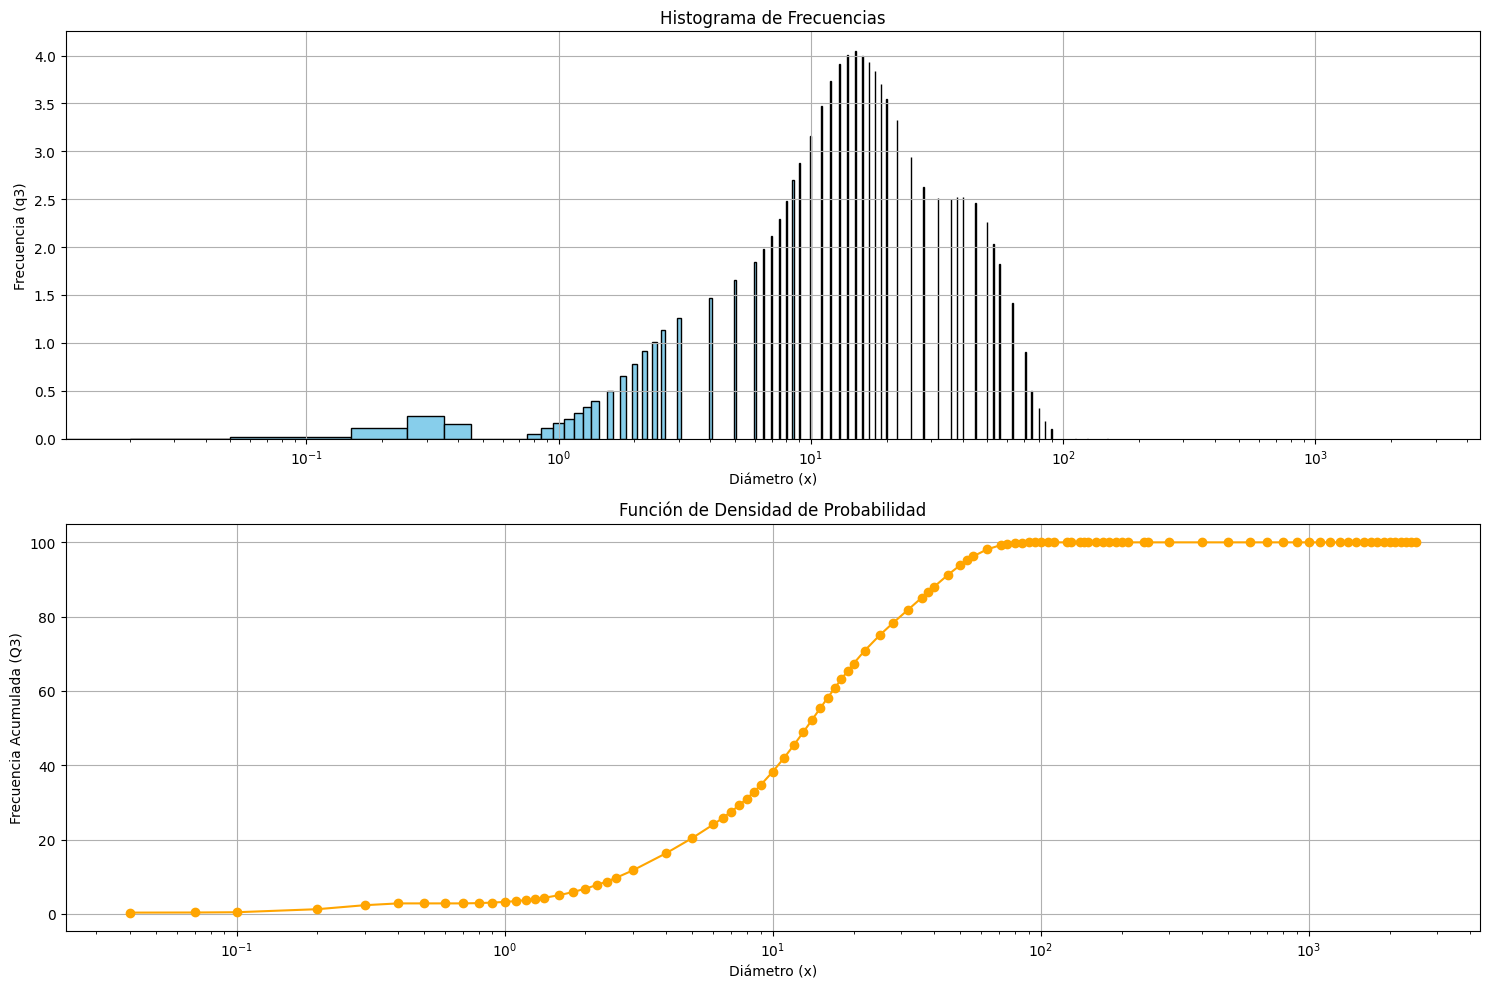

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Seleccionar una muestra
idx = df[df.iloc[:, 0] == input_1].index[0]
# Extraer la fila seleccionada y las dos siguientes
filas_relevantes = df.iloc[idx:idx+3]

# Graficar el histograma
plt.figure(figsize=(15, 10))

# Subgráfico 1: Histograma
plt.subplot(2, 1, 1)
plt.bar(filas_relevantes.iloc[0,2:], filas_relevantes.iloc[2,2:], width=0.1, color='skyblue', edgecolor='black')
# Ajustar el eje x a escala logarítmica
plt.xscale('log')
plt.grid(True)
plt.xlabel('Diámetro (x)')
plt.ylabel('Frecuencia (q3)')
plt.title('Histograma de Frecuencias')

# Subgráfico 2: Función de Densidad de Probabilidad
plt.subplot(2, 1, 2)
plt.plot(filas_relevantes.iloc[0,2:], filas_relevantes.iloc[1,2:], marker='o', linestyle='-', color='orange')
# Ajustar el eje x a escala logarítmica
plt.xscale('log')

plt.xlabel('Diámetro (x)')
plt.ylabel('Frecuencia Acumulada (Q3)')
plt.title('Función de Densidad de Probabilidad')
plt.grid(True)
plt.tight_layout()
plt.show()

Elegir archivo (abajo a la derecha dá la opción de exportarlo):

In [1]:
downloads = 'GeoB22729-20240806-004219.csv'

In [4]:
import pandas as pd
# Ruta a la carpeta que contiene los archivos CSV
ruta = '/work/file_input_uploads/'
pd.read_csv(ruta+downloads).T

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
GeoB_29_3,*,*,GeoB_29_13,*,*,GeoB_29_23,*,*,GeoB_29_13bis,*,...,*,GeoB29_113_Bis,*,*,GeoB29_133_Bis,*,*,GeoB29_153_Bis,*,*
x,Q3,q3,x,Q3,q3,x,Q3,q3,x,Q3,...,q3,x,Q3,q3,x,Q3,q3,x,Q3,q3
0.04,0.29,0.0,0.04,0.38,0.0,0.04,0.31,0.0,0.04,0.3,...,0.0,0.04,0.25,0.0,0.04,0.29,0.0,0.04,0.28,0.0
0.07,0.31,0.0,0.07,0.4,0.0,0.07,0.32,0.0,0.07,0.32,...,0.0,0.07,0.26,0.0,0.07,0.31,0.0,0.07,0.3,0.0
0.10,0.37,0.02,0.1,0.47,0.02,0.1,0.37,0.01,0.1,0.37,...,0.02,0.1,0.31,0.01,0.1,0.34,0.01,0.1,0.33,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100.0,100.0,0.0,2100.0,100.0,0.0,2100.0,100.0,0.0,2100.0,100.0,...,0.0,2100.0,100.0,0.0,2100.0,100.0,0.0,2100.0,100.0,0.0
2200.0,100.0,0.0,2200.0,100.0,0.0,2200.0,100.0,0.0,2200.0,100.0,...,0.0,2200.0,100.0,0.0,2200.0,100.0,0.0,2200.0,100.0,0.0
2300.0,100.0,0.0,2300.0,100.0,0.0,2300.0,100.0,0.0,2300.0,100.0,...,0.0,2300.0,100.0,0.0,2300.0,100.0,0.0,2300.0,100.0,0.0
2400.0,100.0,0.0,2400.0,100.0,0.0,2400.0,100.0,0.0,2400.0,100.0,...,0.0,2400.0,100.0,0.0,2400.0,100.0,0.0,2400.0,100.0,0.0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=084ffeb8-c312-4b61-a7bf-9d0713d90946' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>